# MATH50003 Numerical Analysis: Problem Sheet 2

This week we look at other variants of finite-differences, including central differences and second-order
finite-differences. We also investigate mathematical properties of dual numbers, extend their implementation to
other functions. Finally, we see how dual numbers can be combined with Newton iteration for root finding.

Questions marked with a ‚ãÜ are meant to be completed without using a computer.

## 1. Finite-differences

**Problem 1.1‚ãÜ** Use Taylor's theorem to derive an error bound for central differences
$$
f'(x) ‚âà {f(x + h) - f(x - h) \over 2h}.
$$
Find an error bound when implemented in floating point arithmetic, assuming that
$$
f^{\rm FP}(x) = f(x) + Œ¥_x
$$
where $|Œ¥_x| \leq c œµ_{\rm m}$.

**Problem 1.2** Implement central differences for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$. 
Plot the errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`. 
Derive the error exactly for the different cases to explain the observed behaviour.


**Problem 1.3‚ãÜ** Use Taylor's theorem to derive an error bound on the second-order derivative approximation
$$
f''(x) ‚âà {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
Find an error bound when implemented in floating point arithmetic, assuming that
$$
f^{\rm FP}(x) = f(x) + Œ¥_x
$$
where $|Œ¥_x| \leq c œµ_{\rm m}$.

**Problem 1.4** Use finite-differences, central differences, and second-order finite-differences to approximate to 5-digits the first and second 
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + \ddots}}},
$$
e.g.:
$$
\begin{align*}
f^{\rm s}_1(x) &= 1 + {x-1 \over 2} \\
f^{\rm s}_2(x) &= 1 + {x-1 \over 2 + {x -1 \over 2}} \\
f^{\rm s}_3(x) &= 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}
\end{align*}
$$

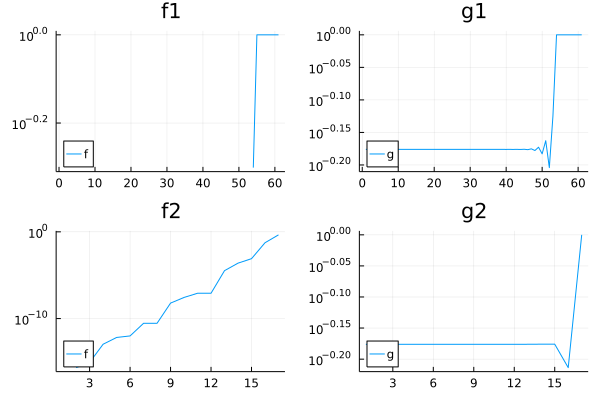

In [11]:
# Problem 1.2 
using Plots
f = x -> 1 + x + x^2 
g = x -> 1 + x/3 + x^2

# Central Difference
h = 2.0 .^ (0:-1:-60)
k = 10.0 .^ (0:-1:-16)
nanabs = x -> iszero(x) ? NaN : abs(x) # avoid 0's in log scale plot

f1 = plot(nanabs.((f.(h) .- f.(-h)) ./ (2 .* h) .- 1);  yscale=:log10, label="f", legend=:bottomleft)
g1 = plot(nanabs.((g.(h) .- g.(-h)) ./ (2 .* h) .- 1); yscale=:log10, label = "g", legend=:bottomleft)

f2 = plot(nanabs.((f.(k) .- f.(-k)) ./ (2 .* k) .- 1);  yscale=:log10, label="f", legend=:bottomleft)
g2 = plot(nanabs.((g.(k) .- g.(-k)) ./ (2 .* k) .- 1); yscale=:log10, label = "g", legend=:bottomleft)

plot(f1, g1, f2, g2, layout=4, title = ["f1" "g1" "f2" "g2"])

In [46]:
# Problem 1.4

function func0(x, n)
    exp(exp(x)*cos(x)+sin(x))
end

function func2(x, n)
    result = 1
    for i = 1:1000
        result *= x/i - 1
    end
    result
end

function func3(x, n)
    if n==1
        1 + (x-1) / 2
    else
        1 + (x-1) / (1 + func3(x, n-1))
    end
end

x = 0.1
h = 1.5e-8
nanabs = x -> iszero(x) ? NaN : abs(x) # avoid 0's in log scale plot

using StatsBase

function diffs(name, h, func, n=1000)
    result = 0

    if name=="finite"
        result = (func(x + h, n) - func(x, n)) / (h)
    elseif name=="second"
        result = (func(x + h) - func(x - h)) / (2 * h)
    elseif name=="central"
        result = (func(x + h) + func(x - h) - 2 * func(x)) / (h ^ 2)
    end
    result
end
print([diffs("finite", h, func0) diffs("finite", h, func2) diffs("finite", h, func3)])

[6.584772579050954 -3.5938262847127573 1.581138768062355]

## 2. Dual numbers

**Problem 2.1‚ãÜ** 
Show that dual numbers $ùîª$ are a _commutative ring_, that is, for all $a,b,c ‚àà ùîª$ the following are satisfied:
1. _additive associativity_: $(a + b) + c = a + (b + c)$
2. _additive commutativity_: $a + b = b + a$
3. _additive identity_: There exists $0 ‚àà ùîª$ such that $a + 0 = a$.
4. _additive inverse_: There exists $-a$ such that $(-a) + a = 0$.
5. _multiplicative associativity_: $(ab)c = a(bc)$
6. _multiplictive commutativity_: $ab = ba$
7. _multiplictive identity_: There exists $1 ‚àà ùîª$ such that $1a= a$.
8. _distributive_: $a(b+c) = ab + ac$

**Problem 2.2‚ãÜ** A _field_ is a commutative ring such that $0 ‚â† 1$ and all nonzero elements have a multiplicative inverse, i.e.,
there exists $a^{-1}$ such that $a a^{-1} = 1$. Why isn't $ùîª$ a field?

**Problem 2.3‚ãÜ** A _matrix representation_ of a ring are maps from a group/ring to matrices such that matrix addition and multiplication
behave exactly like addition and multiplication that of the ring. 
That is, if $A$ and $B$ are elements of the ring and $œÅ$ is a representation, then
$$
œÅ(A + B) = œÅ(A) + œÅ(B) \hbox{ and } œÅ(AB) = œÅ(A)œÅ(B).
$$
Show that the following are matrix representations of complex numbers and
dual numbers (respectively):
$$
\begin{align*}
a + b {\rm i} &\mapsto \begin{pmatrix} a & b \\ -b & a \end{pmatrix} \\
a + b {\rm i} &\mapsto \begin{pmatrix} a & b \\ 0 & a \end{pmatrix}
\end{align*}
$$


**Problem 2.4‚ãÜ** What is the correct definition of division on dual numbers, i.e.,
$$
(a + b \epsilon )/(c + d \epsilon ) = s + t \epsilon
$$
for what choice of $s$ and $t$? Use dual numbers to compute the derivative of the following functions at $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^3 \left({x \over k}-1\right),\hbox{ and } f^{\rm s}_2(x) = {1 + {x - 1 \over 2 + {x-1 \over 2}}}
$$


**Problem 2.5** Add support for `cos`, `sin`, and `/` to the type `Dual`:

In [40]:
# Dual(a,b) represents a + b*œµ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*œµ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0œµ

# Allow for a + b*œµ syntax
const œµ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, sin

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# Algebraic operationds for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

function cos(x::Dual)
    # TODO: implement cos for Duals
    Dual(cos(x.a), -(x.b * sin(x.a)))
end

function sin(x::Dual)
    # TODO: implement sin for Duals
    Dual(sin(x.a), (x.b * cos(x.a)))
end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals
    Dual(x.a / y.a, (x.b * y.a - x.a * y.b)/(y.a^2) )
end

/ (generic function with 136 methods)

In [96]:
# Problem 2.6
x = 0.1 + œµ

function func60(x::Dual, n)
    exp(exp(x)*cos(x)+sin(x))
end

function func62(x::Dual, n)
    result = 1
    for i = 1:1000
        result *= x/i - 1
    end
    result
end

function func63(x::Dual, n)
    if n==1
        1 + (x-1) / 2
    else
        1 + (x-1) / (1 + func3(x, n-1))
    end
end

print([func60(x,1000).b func62(x,1000).b func63(x,1000).b])

[6.5847725546108276 -3.593826513101571 1.5811388300841893]

In [99]:
func60(Dual(1.0),1000)

Dual{Float64}(10.076086313737608, 0.0)

**Problem 2.6** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 1.4?


## 3. Newton iteration

Newton iteration is an algorithm for computed roots of a function $f$ using its derivative: given an initial guess $x_0$, one
obtains a sequence of guesses via
$$
x_{k+1} = x_k - {f(x_k) \over f'(x_k)}
$$

**Problem 3.1** Use `Dual` to implement the following function which returns $x_n$:

In [103]:
function newton(f, x0, n)
    ## TODO: compute x_n
    # x0 is a dual
    if n==1
        x0.a
    else
        xk = Dual(newton(f, x0, n-1))
        xk.a - (f(xk).a / (f(xk + œµ).b)) # as Dual implementation supports both Dual and Real
    end
end

newton (generic function with 1 method)

**Problem 3.2** Compute points $y$ such that $|f(y)| \leq 10^{-13}$ (i.e., approximate roots):
$$
\exp(\exp x \cos x + \sin x)-6\hbox{ and } \prod_{k=1}^{1000} \left({x \over k}-1\right) - {1 \over 2}
$$
(Hint: you may need to try different `x0` and `n` to get convergence. Plotting the function should give an
indication of a good initial guess.)

**Problem 3.3** Compute points $y$ such that $|f^{\rm s}_{1000}(y) - j| \leq 10^{-13}$ for $j = 1,2,3$. 
Make a conjecture of what $f^{\rm s}_n(x)$ converges to as $n ‚Üí ‚àû$. (Bonus problem: Prove your conjecture.)

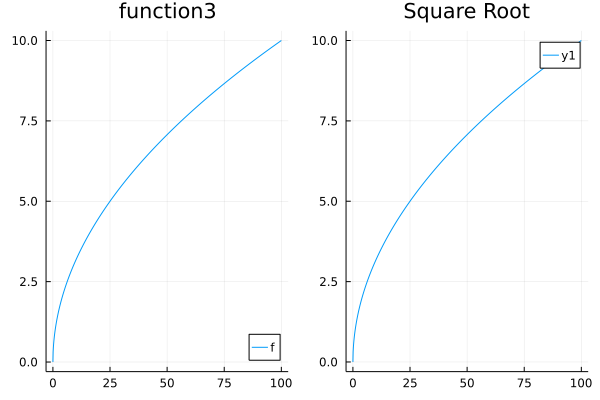

In [136]:
# Problem 3.2

function func0(x::Dual, n)
    exp(exp(x)*cos(x)+sin(x)) - Dual(6.0)
end

function func2(x::Dual, n)
    result = 1
    for i = 1:1000
        result *= x/i - 1
    end
    result-Dual(0.5)
end

function func3(x::Dual, n)
    if n==1
        1 + (x-1) / 2
    else
        1 + (x-1) / (1 + func3(x, n-1))
    end
end

thres = 1e-13
x_vals = (0:0.1:100)
y_vals = []
for x in x_vals
    y = func3(Dual(x),1000).a
    push!(y_vals,y)
end
#print(y_vals)

# Choose n=100 x0=3

function findRoot(func, n, x0, thres, root)
    err = abs(func(x0,1000).a-root)
    i = 1
    while err > thres && i < n
        x = newton(func, x0, i)
        err = abs(func(Dual(x),1000).a)
        i+=1
    end
    print(err)
    x
end
# findRoot(func3, 1000, Dual(5.0), thres)

func3_plt = plot(x_vals, y_vals; label="f", legend=:bottomright)
sqrt_plt = plot(x_vals, (x_vals) .^ 0.5)
plot(func3_plt, sqrt_plt, layout = 2, title = ["function3" "Square Root"])

Final problem: Banach fixed point theorem in a complete function space, implies $f=1+\frac{x-1}{1+f}$, which gives $f = \sqrt{x}$